<a href="https://colab.research.google.com/github/oriol-pomarol/codegeo_workshops/blob/main/7_exploring_vision_with_cnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8. Hybrid modelling - Combining ML and process-based simulations

In this series of workshops we have shown how ML models can effectively learn from any data that we feed them. However, in science, a large corpus of knowledge has been aquired in the form of equations and other theoretical knowledge. It would be great to use that knowledge to inform our ML models, allowing them to improve their predictions, right? That's exactly what we are going to do by exploring the world of hybrid modelling; models that combine process-based simulations with machine learning models to (hopefully) improve both.

## 8.1 Introduction to hybrid modelling

### Why Hybrid Models?
Combining process-based models with machine learning offers several advantages:
-  **Consistency with physical knowledge**: ML models can violate physical laws (e.g., conservation of mass). Hybrid models can enforce these constraints.
-  **Smaller data requirements**: Physical models provide a strong prior, reducing the amount of training data needed for the ML component.
-  **Extrapolation**: Physical models generalize better to unseen conditions (e.g., climate change scenarios) than pure ML models.

### Introducing Scientific Knowledge (Willard et al., 2023)
There are three main ways to introduce scientific knowledge into ML:
1.  **Loss Function**: Adding physical constraints (e.g., energy conservation) to the loss function.
2.  **Initialization**: Pre-training the ML model on simulated data from a physical model, then fine-tuning on observations. **We will focus on this approach.**
3.  **Architecture**: Designing the neural network architecture to reflect physical processes (e.g., mass balance layers).

### Types of Hybrid Models (Reichstein et al., 2019)
Hybrid models can be categorized into:
1.  **Improving Parameterizations**: Using ML to estimate parameters for physical models.
2.  **Replacing a Sub-model**: Replacing a computationally expensive or poorly understood physical process with an ML model.
3.  **Model-Observation Mismatch**: Using ML to correct the errors of a physical model. **We will focus on this.**
    *   **Input Coupling**: Feeding the physical model output as an input to the ML model.
    *   **Residual Modelling**: Predicting the residual (error) of the physical model and adding it to the physical prediction.
4.  **Constraining Submodels**: Using physical knowledge to constrain ML predictions.
5.  **Surrogate Modelling**: Emulating the entire physical model with ML for speed.

## 8.2 Problem Description and Data

We aim to predict streamflow (discharge) at Basel. We will use the same dataset as in the first workshop, which includes meteorological variables (precipitation, temperature, evapotranspiration) and the observed discharge at Basel.

![picture](images/basel_discharge.jpg)

Additionally, we will use the simulated discharge from the **PCR-GLOBWB** global hydrological model. PCR-GLOBWB simulates the water cycle based on physical equations. We will use its output ('pcr') as a representation of physical knowledge.

We first import the necessary libraries and load the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

# Load data
input_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/pred_basel.csv", delimiter=",", on_bad_lines='skip', index_col=0)
output_data = pd.read_csv("https://raw.githubusercontent.com/oriol-pomarol/final_thesis_project/main/data/q_basel.csv", delimiter = ",", on_bad_lines='skip', index_col=0)

# Select variables, including the physical model output 'pcr'
# Note: We assume the column 'pcr' exists in the input dataset representing the PCR-GLOBWB simulation.
input_data = input_data[['p', 't', 'et']]
output_data = output_data[['obs', 'pcr']]

# Drop missing values
combined = pd.concat([input_data, output_data], axis=1).dropna()
input_data = combined[['p', 't', 'et', 'pcr']]
output_data = combined[['obs']]

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(input_data, output_data, test_size=0.1, shuffle=False)

print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")

Training samples: 6574, Test samples: 731


### Baseline: PCR-GLOBWB Performance

Before building any hybrid models, it is important to establish a baseline. How well does the physical model (PCR-GLOBWB) perform on its own?

In [2]:
# Evaluate PCR-GLOBWB directly
pcr_r2 = r2_score(y_test, X_test['pcr'])
pcr_rmse = root_mean_squared_error(y_test, X_test['pcr'])

print("Physical Model Performance (PCR-GLOBWB):")
print(f"R2: {pcr_r2:.3f}")
print(f"RMSE: {pcr_rmse:.3f}")

Physical Model Performance (PCR-GLOBWB):
R2: 0.227
RMSE: 487.852


## 8.3 Hybrid Modelling Implementations

We will now implement three different models to predict streamflow and compare them.

### Pure ML Model

First, we train a standard Machine Learning model (Random Forest) using only the meteorological inputs (precipitation, temperature, evapotranspiration). This model has no access to the physical model's output.

In [3]:
# Train Random Forest with ONLY meteo inputs (p, t, et)
# We exclude 'pcr' to see how well ML does on its own.
X_train_meteo = X_train[['p', 't', 'et']]
X_test_meteo = X_test[['p', 't', 'et']]

model_pure = RandomForestRegressor(random_state=42)
model_pure.fit(X_train_meteo, y_train.values.ravel())

# Predict
pred_pure = model_pure.predict(X_test_meteo)

# Evaluate
pure_r2 = r2_score(y_test, pred_pure)
pure_rmse = root_mean_squared_error(y_test, pred_pure)

print("Pure ML Model Performance:")
print(f"R2: {pure_r2:.3f}")
print(f"RMSE: {pure_rmse:.3f}")

Pure ML Model Performance:
R2: 0.073
RMSE: 534.503


### Initialization (Pre-training)

Here we use a Neural Network (MLP). We first "pre-train" the network to mimic the physical model (PCR-GLOBWB). This initializes the network weights with physical knowledge. Then, we "fine-tune" the network on the observed data. This allows the model to start from a physically consistent state and adapt to reality.

In [24]:
# Initialize MLP Regressor
# warm_start=True allows us to continue training
model_init = MLPRegressor(hidden_layer_sizes=(64, 64), random_state=42, max_iter=500, warm_start=True)

# Step 1: Pre-train on PCR-GLOBWB output
# We want the model to learn the mapping from Meteo -> PCR
print("Pre-training on Physical Model...")
model_init.fit(X_train_meteo, X_train['pcr'])

# Check how well it learned PCR
pcr_pred_init = model_init.predict(X_test_meteo)
init_pcr_r2 = r2_score(X_test['pcr'], pcr_pred_init)
print(f"Pre-training R2 on PCR: {init_pcr_r2:.3f}")

Pre-training on Physical Model...
Pre-training R2 on PCR: 0.206
Pre-training R2 on PCR: 0.206


In [25]:
# Step 2: Fine-tune on Observed Data
# We continue training to map Meteo -> Obs
print("Fine-tuning on Observations...")
model_init.fit(X_train_meteo, y_train.values.ravel())

# Predict
pred_init = model_init.predict(X_test_meteo)

# Evaluate
init_r2 = r2_score(y_test, pred_init)
init_rmse = root_mean_squared_error(y_test, pred_init)

print("Method 3 (Initialization/Pre-training) Performance:")
print(f"R2: {init_r2:.3f}")
print(f"RMSE: {init_rmse:.3f}")

Fine-tuning on Observations...
Method 3 (Initialization/Pre-training) Performance:
R2: -0.016
RMSE: 559.360
Method 3 (Initialization/Pre-training) Performance:
R2: -0.016
RMSE: 559.360


### Input Coupling (Error Correction)

The simplest way to integrate a physical model into an ML workflow is to use its output as an additional input feature. The ML model can then learn to correct the physical model's biases or combine it with other meteorological data.

In [26]:
# Train Random Forest with p, t, et, AND pcr as inputs
model_input = RandomForestRegressor(random_state=42)
model_input.fit(X_train, y_train.values.ravel())

# Predict
pred_input = model_input.predict(X_test)

# Evaluate
input_r2 = r2_score(y_test, pred_input)
input_rmse = root_mean_squared_error(y_test, pred_input)

print("Method 1 (Input Coupling) Performance:")
print(f"R2: {input_r2:.3f}")
print(f"RMSE: {input_rmse:.3f}")

Method 1 (Input Coupling) Performance:
R2: 0.568
RMSE: 365.005


## 8.4 Comparison

Let's compare the performance of all methods.

In [27]:
# Create a comparison table
pd.DataFrame({
    'Model': ['PCR-GLOBWB (Baseline)', 'Pure ML (RF)', 'Initialization (MLP)', 'Input Coupling (RF)'],
    'R2': [pcr_r2, pure_r2, init_r2, input_r2],
    'RMSE': [pcr_rmse, pure_rmse, init_rmse, input_rmse]
})

,Model,R2,RMSE
0,PCR-GLOBWB (Baseline),0.227464,487.852416
1,Pure ML (RF),0.072655,534.502771
2,Initialization (MLP),-0.015604,559.360037
3,Input Coupling (RF),0.567547,365.004687


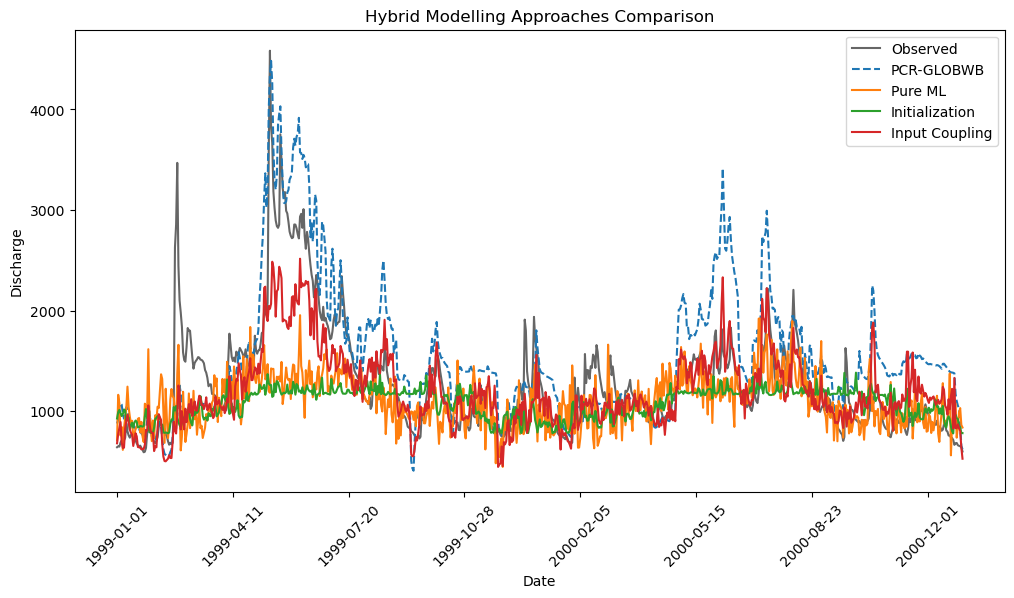

In [28]:
# Plotting
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test['obs'], label='Observed', color='black', alpha=0.6)
plt.plot(y_test.index, X_test['pcr'], label='PCR-GLOBWB', linestyle='--')
plt.plot(y_test.index, pred_pure, label='Pure ML')
plt.plot(y_test.index, pred_init, label='Initialization')
plt.plot(y_test.index, pred_input, label='Input Coupling')

plt.legend()
plt.title('Hybrid Modelling Approaches Comparison')
plt.ylabel('Discharge')
plt.xlabel('Date')
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10)) # Reduce x-ticks
plt.xticks(rotation=45)
plt.show()